### Requirements

In [1]:
from dataset import*
from utility import*
from training import*
from baseline import*
from transformer import*

# Head pose DL model from https://github.com/thohemp/6drepnet
from sixdrepnet import SixDRepNet
import dlib

from torch.optim import lr_scheduler 
# Import models
from torchvision import models
from vit_pytorch.twins_svt import TwinsSVT # MEMORIA NON SUFFICIENTE RIPROVARLO
#from vit_pytorch.vit import ViT
from vit_pytorch.ats_vit import ViT
from vit_pytorch import SimpleViT
from vit_pytorch.crossformer import CrossFormer # MEMORIA NON SUFFICIENTE RIPROVARLO
from vit_pytorch.cross_vit import CrossViT

In [2]:
root_project = '/home/anto/University/Driving-Visual-Attention/'

In [3]:
print(f"We have {'' if torch.cuda.is_available() else 'not'} access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
print(device)

We have  access to a GPU
0
1
NVIDIA GeForce RTX 3060 Laptop GPU
cuda


In [4]:
seed_everything(42)

##### Initialize pre-trained models for feature extraction

In [5]:
# Initialize face detector and facial landmarks predictor
predictor = dlib.shape_predictor("/home/anto/University/Driving-Visual-Attention/data/shape_predictor_68_face_landmarks.dat")
headpose_extractor = SixDRepNet()
face_detector = dlib.get_frontal_face_detector()

### Data Loader and Visualization

##### Files where to write the paths and labels

In [6]:
percentage = 100
save_train_file = root_project + 'save/save_train' + str(percentage)+'_complete'
save_val_file = root_project + 'save/save_val' + str(percentage)+'_complete'
save_test_file = root_project + 'save/save_test' + str(percentage)+'_complete'

##### Train Validation and Test Loader

In [7]:
#train_dataset_classloader = DataLoaderVisualizer(root_project, save_train_file, percentage, predictor, face_detector, headpose_extractor, 'train',big_file=False)
#val_dataset_classloader = DataLoaderVisualizer(root_project,save_val_file,percentage,predictor, face_detector, headpose_extractor,'val',big_file=False)
#test_dataset_classloader = DataLoaderVisualizer(root_project,save_val_file,percentage,predictor, face_detector, headpose_extractor,'test',big_file=False)

##### Visualization

In [8]:
#train_dataset_classloader.visualize_dataset()
#val_dataset_classloader.visualize_dataset()
#test_dataset_classloader.visualize_dataset()

### Pytorch Dataset 

In [9]:
# Choose size of the face
dim = (224,224)
# mean and std of images, calculated in advance
mean = (0.4570, 0.4422, 0.3900)
std = (0.2376, 0.2295, 0.2261)

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(dim, antialias=True),
    transforms.Normalize(mean=mean, std=mean, inplace=True)
])

In [10]:
train_dataset = DGAZEDataset('train', save_train_file, my_transforms, big_file=True)
print(f'Train dataset len is {len(train_dataset)}')

Train dataset len is 187458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The bbox is: tensor([1397.,  506., 2550., 1010.])
The additional features are: tensor([227., 487., 367., 488., 248., 575., 204., 488., 255., 491., 334., 491.,
        399., 488.])


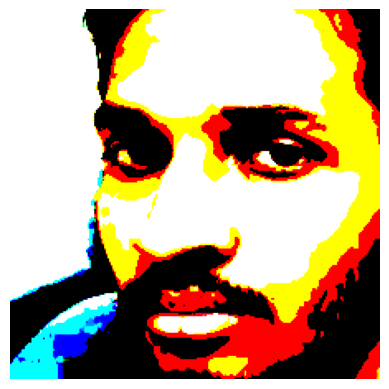

In [11]:
# Print an example of the dataset for correct visualization
img_np = train_dataset[30][0].permute(1, 2, 0).numpy()*255
print(f"The bbox is: {train_dataset[30][3]}")
print(f"The additional features are: {train_dataset[30][1]}")
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [12]:
val_dataset = DGAZEDataset('val',save_val_file,my_transforms, big_file=True)
print(f'Val dataset len is {len(val_dataset)}')

Val dataset len is 23317


In [13]:
#test_dataset = DGAZEDataset('test',save_test_file, my_transforms)
#print(f'Test dataset len is {len(test_dataset)}')

In [14]:
# Unite datasets, increse samples in the training or validation
#from torch.utils.data import ConcatDataset
#val_dataset = ConcatDataset([val_dataset,test_dataset])
#train_dataset = ConcatDataset([train_dataset,test_dataset])

### Vision Transformer Model

##### Hyerparameters

In [15]:
EPOCHS = 10
BATCH_SIZE = 16
THRESHOLD = 250
LR = 0.01
BETAS = (0.9, 0.97)
WEIGHT_DECAY = 1e-5
STEP_SIZE = 40000
GAMMA = 0.1
pre_trained = False

In [16]:
#model = GazeCNN(additional_features_size=7)
model = CNNTrans(device)
#tensor2 = torch.randn(64,3, 64, 128)
#tensor1 = torch.randn(64,7)
#out = model(tensor2,tensor1)
model.to(device)

CNNTrans(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
weights = torch.load('/home/anto/University/Driving-Visual-Attention/save/cnntransformer.pt')
model.load_state_dict(weights)
# Freeze layers 
for param in model.parameters():
    param.requires_grad = False
# Unfreeze MLPs
for param in model.encoder.layers[-1].parameters():
    param.requires_grad = True
for param in model.feed.parameters():
    param.requires_grad = True

##### Criterion and Optimizer

In [18]:
bbox_accuracy_class = BBoxAccuracy()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)#, betas=BETAS, weight_decay= WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

##### Dataloader

In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training 

In [20]:
if pre_trained:
    ckpt_path = '/home/anto/University/Driving-Visual-Attention/save/cnntransformer7epoch.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [21]:
wandb.login()
wandb.init(project="Transformer Nick", name=f"threshold={THRESHOLD}, batch_size={BATCH_SIZE}, normalization,{percentage}=percent, weight_decay={WEIGHT_DECAY}, lr={LR},betas={BETAS}, gamma={GAMMA}, step_size={STEP_SIZE} no additional features")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: scardino-2020613 (vesuvio-erutta). Use `wandb login --relogin` to force relogin


In [22]:
if pre_trained:
    start_epoch = checkpoint['epoch']
    EPOCHS = start_epoch + EPOCHS
else:
    start_epoch = 0
    EPOCHS = EPOCHS

for epoch in range(start_epoch, EPOCHS):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, scheduler, optimizer, device, epoch)
    wandb.log({"epoch": epoch + 1,"train_loss": train_loss})

    # Validation
    val_loss, val_accuracy, bbox_accuracy, paper_accuracy = validate(model, bbox_accuracy_class , val_loader, THRESHOLD, criterion, device, epoch, BATCH_SIZE)
    wandb.log({"epoch": epoch + 1,"val_loss": val_loss})
    wandb.log({"epoch": epoch + 1,"accuracy_threshold": val_accuracy*100})
    wandb.log({"epoch": epoch + 1,"accuracy_bbox": bbox_accuracy*100})
    wandb.log({"epoch": epoch + 1,"accuracy_paper(error)": paper_accuracy})

    #log_image(val_loader, model, device)

# Finish the WandB run
wandb.finish()

Training Epoch 0:  37%|███▋      | 4308/11716 [03:51<06:19, 19.53batch/s, batch loss=87.37] 

In [ ]:
save_dict = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(save_dict, root_project + 'save/cnntransformer_epochs' + str(EPOCHS)+'_'+str(THRESHOLD)+'.pth')